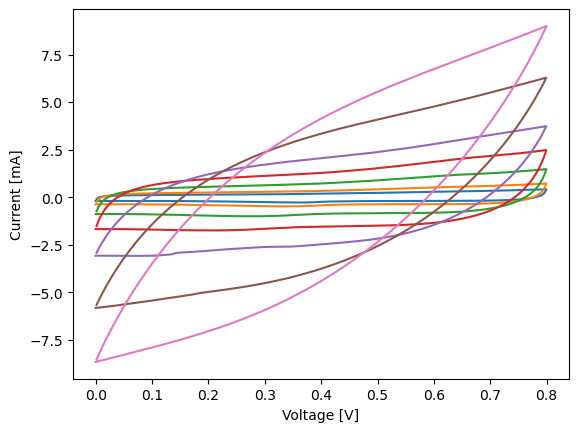

,Scan rate,Vmax,C_abs,C_sp,C_areal,E_abs,E_sp,E_areal,P_abs,P_sp,P_areal
0,1.0,0.8,0.812,154.399,0.315,0.0722,13.729,0.0280,0.325,61.798,0.126
1,2.0,0.8,0.735,139.758,0.285,0.0653,12.417,0.0253,0.588,111.806,0.228
2,5.0,0.8,0.626,119.032,0.243,0.0556,10.572,0.0216,1.251,237.873,0.485
3,10.0,0.8,0.525,99.827,0.203,0.0467,8.880,0.0181,2.102,399.688,0.815
4,20.0,0.8,0.365,69.404,0.141,0.0324,6.161,0.0126,2.916,554.467,1.130
5,50.0,0.8,0.205,38.980,0.079,0.0182,3.461,0.0071,4.095,778.650,1.587
6,100.0,0.8,0.120,22.818,0.047,0.0107,2.035,0.0041,4.815,915.556,1.866


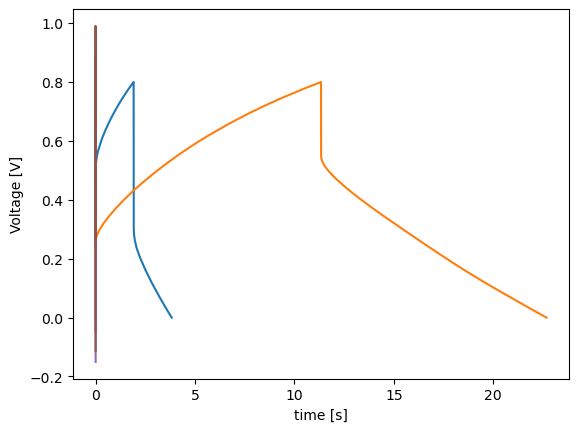

,I_gcd,Vmax,C_abs,C_sp,C_areal,E_abs,E_sp,E_areal,P_abs,P_sp,P_areal
5,0.2,0.8,0.00,0.000,0.000,0.0000,0.000,0.0000,0.000,0.000,0.000
4,0.5,0.8,0.00,0.000,0.000,0.0000,0.000,0.0000,0.000,0.000,0.000
3,1.0,0.8,0.00,0.000,0.000,0.0000,0.000,0.0000,0.000,0.000,0.000
2,2.0,0.8,0.00,0.000,0.000,0.0000,0.000,0.0000,0.000,0.000,0.000
1,5.0,0.8,0.28,53.241,0.109,0.0249,4.735,0.0097,3.953,751.650,1.532
0,10.0,0.8,0.10,19.015,0.039,0.0089,1.692,0.0034,8.361,1589.816,3.241


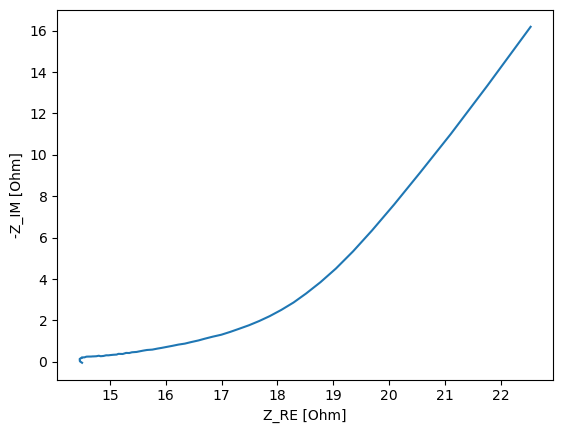

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import csv
import io
from IPython.display import display

# this function imports a CV data file, clean it, and extracts last cycle data, scan rate, and Vmax
def read_file_CV(filename):
    # Read lines from the file
    with open(f"Input_data/{filename}", 'r', encoding='ISO-8859-1') as f:
        lines = f.readlines()

    # Loop through lines and extract row numbers for specific lines using string prefixes
    for i, line in enumerate(lines):
        if line.startswith("dE/dt  "):
            scan_rate_row = i
        elif line.startswith("E1"):
            Vmax_row = i
        elif line.startswith("nc cycles"):
            cycle_row = i
        elif line.startswith("mode"):
            headerline_row = i - 3     # Subtract 3 to account for empty rows
            break

    # Extract scan rate, Vmax, and cycle values
    scan_rate = float(pd.read_csv(f"Input_data/{filename}", encoding='ISO-8859-1', skiprows=range(1, scan_rate_row), nrows=1)["EC-Lab ASCII FILE"].iloc[0][20:])
    Vmax = float(pd.read_csv(f"Input_data/{filename}", encoding='ISO-8859-1', skiprows=range(1, Vmax_row), nrows=1)["EC-Lab ASCII FILE"].iloc[0][20:])
    cycle = float(pd.read_csv(f"Input_data/{filename}", encoding='ISO-8859-1', skiprows=range(1, cycle_row), nrows=1)["EC-Lab ASCII FILE"].iloc[0][20:])

    # Remove empty lines and read data to extract last cycle VI data
    lines = [line for line in lines if line.strip()]
    data = pd.read_csv(io.StringIO(''.join(lines)), header=headerline_row, sep="\t", encoding='ISO-8859-1')
    last_cycle_VI_data = data[data["cycle number"] == cycle][["Ewe/V", "<I>/mA"]].assign(filename=filename)
    
    return last_cycle_VI_data, scan_rate, Vmax


# this function calculates secondary parameters from a CV curve
def calculate_sec_param_CV(data, scan_rate, Vmax, AL_mass, Area_two_elec):
    data["delta_x"] = data["Ewe/V"].diff()
    data["segment_area"] = data["delta_x"] * data["<I>/mA"]
    VI_area = data["segment_area"].sum()
    C_abs = round(4 * 0.5 * VI_area / scan_rate / Vmax, 3)
    C_sp = round(C_abs / AL_mass, 3)
    C_areal = round(C_abs / Area_two_elec, 3)
    E_abs = round(0.5 * C_abs * Vmax * Vmax / 3.6, 4)
    E_sp = round(E_abs / AL_mass, 3)
    E_areal = round(E_abs / Area_two_elec, 4)
    t_disc = Vmax / scan_rate * 1000
    P_abs = round(E_abs * 3600 / t_disc , 3)
    P_sp = round(P_abs / AL_mass, 3)
    P_areal = round (P_abs / Area_two_elec, 3)
    return {"Scan rate":scan_rate, "Vmax":Vmax, "C_abs":C_abs, "C_sp":C_sp, "C_areal":C_areal, "E_abs":E_abs, "E_sp":E_sp, "E_areal":E_areal, "P_abs":P_abs, "P_sp":P_sp, "P_areal":P_areal}


# this function imports a GCD data file, cleans it, and extracts primary parameters
def read_file_GCD(filename):
    # Read lines from the file
    with open(f"Input_data/{filename}", 'r', encoding='ISO-8859-1') as f:
        lines = f.readlines()

    # Loop through lines and extract row numbers for specific lines using string prefixes
    for i, line in enumerate(lines):
        if line.startswith("Is "):
            I_gcd_row = i
        elif line.startswith("EM "):
            Vmax_row = i
        elif line.startswith("nc cycles"):
            cycle_row = i
        elif line.startswith("mode"):
            headerline_row = i - 3     # Subtract 3 to account for empty rows
            break
    
    # Extract scan rate, Vmax, and cycle values
    I_gcd = float(pd.read_csv(f"Input_data/{filename}", encoding='ISO-8859-1', skiprows=range(1, I_gcd_row), nrows=1)["EC-Lab ASCII FILE"].iloc[0][20:25])
    Vmax = float(pd.read_csv(f"Input_data/{filename}", encoding='ISO-8859-1', skiprows=range(1, Vmax_row), nrows=1)["EC-Lab ASCII FILE"].iloc[0][20:25])
    cycle = float(pd.read_csv(f"Input_data/{filename}", encoding='ISO-8859-1', skiprows=range(1, cycle_row), nrows=1)["EC-Lab ASCII FILE"].iloc[0][40:])

    # Remove empty lines and read data to extract last cycle VI data
    lines = [line for line in lines if line.strip()]
    data = pd.read_csv(io.StringIO(''.join(lines)), header=headerline_row, sep="\t", encoding='ISO-8859-1')
    Q_disc = data[data["cycle number"] == cycle]['dQ/C'].min()
    time_min = data[data["cycle number"] == cycle]['time/s'].min()
    data = data[data["cycle number"] == cycle][["time/s", "Ewe/V"]].assign(filename=filename)
    data['time/s'] = data['time/s'] - time_min
    
    return data, I_gcd, Vmax, Q_disc, time_min


# this function calculates secondary parameters from a GCD curve
def calculate_sec_param_GCD(data, I_gcd, Q_disc, Vmax, AL_mass, Area_two_elec):
    C_abs = round(4 * -Q_disc / Vmax, 2)
    C_sp = round(C_abs / AL_mass, 3)
    C_areal = round(C_abs / Area_two_elec, 3)
    E_abs = round(0.5 * C_abs * Vmax * Vmax / 3.6, 4)
    E_sp = round(E_abs / AL_mass, 3)
    E_areal = round(E_abs / Area_two_elec, 4)
    t_disc = data['time/s'].max()
    P_abs = round(E_abs * 3600 / t_disc , 3)
    P_sp = round(P_abs / AL_mass, 3)
    P_areal = round (P_abs / Area_two_elec, 3)
    return {"I_gcd":I_gcd, "Vmax":Vmax, "C_abs":C_abs, "C_sp":C_sp, "C_areal":C_areal, "E_abs":E_abs, "E_sp":E_sp, "E_areal":E_areal, "P_abs":P_abs, "P_sp":P_sp, "P_areal":P_areal}


# this function makes an EIS plot cleaner
def filtering_EIS(data):
    # Read lines from the file
    with open(f"Input_data/{filename}", 'r', encoding='ISO-8859-1') as f:
        lines = f.readlines()

    # Loop through lines and extract row numbers for specific lines using string prefixes
    for i, line in enumerate(lines):
        if line.startswith("freq"):
            headerline_row = i - 3     # Subtract 3 to account for empty rows
            break    
    
    lines = [line for line in lines if line.strip()]
    data = pd.read_csv(io.StringIO(''.join(lines)), header=headerline_row, sep="\t", encoding='ISO-8859-1')
#     data = data[data['-Im(Z)/Ohm'] > 0]
#     data = data[data['Re(Z)/Ohm'] > 0]
#     data = data[data['Re(Z)/Ohm'] < 60]
    data = data[['freq/Hz', 'Re(Z)/Ohm', '-Im(Z)/Ohm']]
    
    return data



# Function part ends and execution part starts here
# place all input data (.mpt files) in the Input_data folder beforehand
dir_path = r'C:\Users\Myeong-Lok Seol\Python_code\potentiostat-data-analysis\Input_data'
data_files = os.listdir(dir_path)

# mass was measured after the annealing, and then the AC portion was calculated 
AL_mass = 0.00683 * 0.77   # [g]
Area_two_elec = 2.58       # [cm^2]

# define empty dataframes
sec_parameters_CV = []
sec_parameters_GCD = []
sec_parameters_EIS = []

found_CV_file = False
found_GCD_file = False
found_EIS_file = False

# generating  plot data and secondary dataset
for filename in data_files:
    if "_CV" in filename:
        found_CV_file = True
        data_CV, scan_rate, Vmax_CV = read_file_CV(filename)
        sec_parameters_seg = calculate_sec_param_CV(data_CV, scan_rate, Vmax_CV, AL_mass, Area_two_elec)
        sec_parameters_CV.append(sec_parameters_seg)
        plt.plot(data_CV["Ewe/V"], data_CV["<I>/mA"], label = 'CV')
        plt.xlabel("Voltage [V]")
        plt.ylabel("Current [mA]")
if found_CV_file:
    plt.show()
    sec_parameters_CV = pd.DataFrame(sec_parameters_CV)
    sec_parameters_CV = sec_parameters_CV.sort_values(by=['Scan rate', 'Vmax'], ascending = True)
    display(sec_parameters_CV)

for filename in data_files:
    if "_CP" in filename:
        found_GCD_file = True
        data_GCD, I_gcd, Vmax, Q_disc, time_min = read_file_GCD(filename)
        sec_parameters_seg = calculate_sec_param_GCD(data_GCD, I_gcd, Q_disc, Vmax, AL_mass, Area_two_elec)
        sec_parameters_GCD.append(sec_parameters_seg)
        plt.plot(data_GCD["time/s"], data_GCD["Ewe/V"], label = 'GCD')
        plt.xlabel("time [s]")
        plt.ylabel("Voltage [V]")
if found_GCD_file:
    plt.show()
    sec_parameters_GCD = pd.DataFrame(sec_parameters_GCD)
    sec_parameters_GCD = sec_parameters_GCD.sort_values(by=['I_gcd', 'Vmax'], ascending = True)
    display(sec_parameters_GCD)

for filename in data_files:
    if "_PEIS" in filename:
        found_EIS_file = True
        data_EIS = filtering_EIS(filename)
        data_EIS = data_EIS.iloc[10:]
        plt.plot(data_EIS['Re(Z)/Ohm'], data_EIS['-Im(Z)/Ohm'])
        plt.xlabel('Z_RE [Ohm]')
        plt.ylabel('-Z_IM [Ohm]')
if found_EIS_file:
    plt.show()

# data_CV.to_csv('CV_filtered.csv', index = False, header = False)
# data_GCD.to_csv('GCD_filtered.csv', index = False, header = False)
# data_EIS.to_csv('EIS_filtered.csv', index = False, header = False)
